<a href="https://colab.research.google.com/github/T-Yamaguch/WGAN/blob/master/WGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, \
MaxPooling2D, Activation, ReLU, LeakyReLU, UpSampling2D, BatchNormalization, \
Dropout, Dense, Flatten, Add, LayerNormalization, GaussianNoise, Reshape, Lambda
from keras.regularizers import l2

class conv_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(conv_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = ReLU()
    self.up = UpSampling2D((2,2))
    self.noise = GaussianNoise(0.2)

  def call(self, x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.act(x)
    x = self.up(x)
    x = self.noise(x)
    return x

class res_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(res_block, self).__init__()
    self.conv1 = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.conv2 = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm1 = BatchNormalization(trainable=True)
    self.norm2 = BatchNormalization(trainable=True)
    self.act1 = ReLU()
    self.act2 = ReLU()
    self.add = Add()

  def call(self, x):
    y = self.conv1(x)
    y = self.norm1(y)
    y = self.act1(y)
    y = self.conv2(y)
    y = self.norm2(y)
    y = self.act2(y)
    x = self.add([x, y])
    return x

class disc_block(Model):
  def __init__(self, filter_num, kernel_size, kernel_regularizer= l2(0.001)):
    super(disc_block, self).__init__()
    self.conv = Conv2D(filter_num, kernel_size, padding = 'same', kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = ReLU()
    self.pooling = MaxPooling2D((2,2), strides=(2,2))
    self.drop = Dropout(0.3)

  def call(self, x):
    x = self.conv(x)
    x = self.norm(x)
    x = self.act(x)
    x = self.pooling(x)
    x = self.drop(x)
    return x

class dense_block(Model):
  def __init__(self, filter_num, kernel_regularizer= l2(0.001)):
    super(dense_block, self).__init__()
    self.dense = Dense(filter_num, kernel_regularizer= kernel_regularizer)
    self.norm = BatchNormalization(trainable=True)
    self.act = ReLU()

  def call(self, x):
    x = self.dense(x)
    x = self.norm(x)
    x = self.act(x)
    return x




In [3]:
class Generator():
  def __init__(self):
    self.channel_num = 256
    self.layer_num = 5
    self.res_num = 0
    self.latent_num = 8
    self.inputs = Input(shape=(self.latent_num)) 
    self.kernel_size = (5, 5)
    self.name = 'generator'
    self.kernel_regularizer= l2(1E-8)
      
  def model(self):
    x = self.inputs

    final_size = 4*4*self.channel_num
    data_size = self.latent_num

    while data_size*4 < final_size:
      data_size *= 4
      x = dense_block(data_size, kernel_regularizer= self.kernel_regularizer)(x)

    x = dense_block(final_size, kernel_regularizer= self.kernel_regularizer)(x)
    x = Reshape((4, 4, self.channel_num))(x)

    filter_num = self.channel_num
    
    for n in range(self.layer_num):
      for m in range(self.res_num):
        x = res_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      x = conv_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)

    for m in range(self.res_num):
      x = res_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)

    x = Conv2D(filter_num, self.kernel_size, padding = 'same', kernel_regularizer= self.kernel_regularizer)(x)
    x = BatchNormalization(trainable=True)(x)
    x = ReLU()(x)

    x = Conv2D(3, (1,1), padding='same')(x)
    x = Activation('sigmoid')(x)
    outputs = x
    return Model(inputs = self.inputs, outputs = outputs, name = self.name)

g = Generator()
g.model().summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense_block (dense_block)    (None, 32)                416       
_________________________________________________________________
dense_block_1 (dense_block)  (None, 128)               4736      
_________________________________________________________________
dense_block_2 (dense_block)  (None, 512)               68096     
_________________________________________________________________
dense_block_3 (dense_block)  (None, 2048)              1058816   
_________________________________________________________________
dense_block_4 (dense_block)  (None, 4096)              8409088   
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0 

In [4]:
class Discriminator():
  def __init__(self):
    self.channel_num = 32
    self.layer_num = 3
    self.latent_num = 8
    self.input_shape = (128, 128, 3)
    self.patch_shape = (32, 32, 3)
    self.inputs = Input(shape=self.input_shape)
    self.patch_inputs = Input(shape=self.patch_shape)
    self.kernel_size = (3, 3)
    self.name = 'discriminator'
    self.kernel_regularizer= l2(1E-8)

  def patch_model(self):
    x = self.patch_inputs

    filter_num = self.channel_num
    for n in range(self.layer_num):
      x = disc_block(filter_num, self.kernel_size, kernel_regularizer= self.kernel_regularizer)(x)
      filter_num *= 2

    x = Flatten()(x)
    x = dense_block(32, kernel_regularizer= self.kernel_regularizer)(x)

    # x = Dense(self.latent_num)(x)
    # x = Activation('sigmoid')(x)

    outputs = x

    return Model(inputs = self.patch_inputs, outputs = outputs, name = 'patch_model')

  def model(self):
    x = self.inputs

    h, w = self.input_shape[:-1]
    ph, pw = self.patch_shape[:-1]
    list_row_idx = [(i*ph, (i+1)*ph) for i in range(h//ph)]
    list_col_idx = [(i*pw, (i+1)*pw) for i in range(w//pw)]

    list_patch = []
    for row_idx in list_row_idx:
        for col_idx in list_col_idx:
            x_patch = Lambda(lambda z: z[:, row_idx[0]:row_idx[1], col_idx[0]:col_idx[1], :])(x)
            list_patch.append(x_patch)

    patch_num = (h//ph)*(w//pw)
    # sub_model = self.sub_model(patch_num)
    # x = sub_model(list_patch)

    # outputs = x


    patch_model = self.patch_model()
    x = [patch_model(list_patch[i]) for i in range(patch_num)]

    x = Concatenate(axis=-1)(x)

    # x = dense_block(512, kernel_regularizer= self.kernel_regularizer)(x)

    # x1 = Dense(1)(x)
    # x1 = Activation('tanh')(x1)

    # x2 = Dense(self.latent_num)(x)
    # x2 = Activation('sigmoid')(x2)

    # outputs = [x1, x2]

    outputs = Dense(1)(x)

    return Model(inputs = self.inputs, outputs = outputs, name = self.name)

d = Discriminator()
d.patch_model().summary()
d.model().summary()

Model: "patch_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
disc_block (disc_block)      (None, 16, 16, 32)        1024      
_________________________________________________________________
disc_block_1 (disc_block)    (None, 8, 8, 64)          18752     
_________________________________________________________________
disc_block_2 (disc_block)    (None, 4, 4, 128)         74368     
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense_block_5 (dense_block)  (None, 32)                65696     
Total params: 159,840
Trainable params: 159,328
Non-trainable params: 512
_______________________________________________


epochs 1
steps128

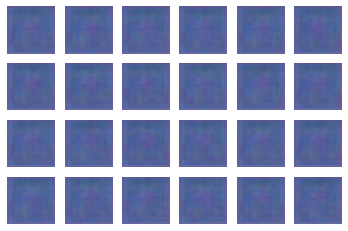


epochs 2
steps128

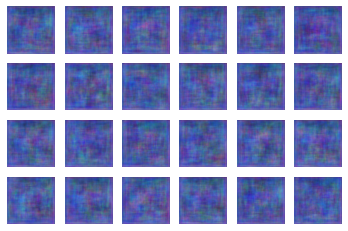


epochs 3
steps47

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import binary_crossentropy, MSE
import glob
import time
import random
import sys

class WGAN():
  def __init__(self, 
               img_size=128, 
               code_num = 2048,
               batch_size = 16, 
               train_epochs = 100, 
               train_steps = 8, 
               checkpoint_epochs = 25, 
               image_epochs = 1, 
               start_epoch = 1,
               optimizer = Adam(learning_rate = 1e-4)
               ):
    
    self.batch_size = batch_size
    self.train_epochs =  train_epochs
    self.train_steps = train_steps
    self.checkpoint_epochs = checkpoint_epochs
    self.image_epochs = image_epochs
    self.start_epoch = start_epoch
    self.code_num = code_num
    self.img_size = img_size
    
    self.gen_optimizer = optimizer
    self.disc_optimizer = optimizer

    g = Generator()
    self.gen = g.model()
    
    d = Discriminator()
    self.disc = d.model()

    checkpoint_dir = "drive/My Drive/WGAN/checkpoint"
    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(gen_optimizer = self.gen_optimizer,
                                     disc_optimizer = self.disc_optimizer,
                                     gen = self.gen,
                                     disc = self.disc,
                                     )

    self.manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=2)

    train_image_path = 'drive/My Drive/samples/image'
    
    self.train_filenames = glob.glob(train_image_path + '/*.jpg') 

    checkpoint.restore(self.manager.latest_checkpoint)

    self.g_history = []
    self.d_history = []
    # self.endec_history = []  

  def preprocess_image(self, image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [self.img_size, self.img_size] )
    image = image/255  # normalize to [0,1] range
    return tf.cast(image, tf.float32)

  def load_and_preprocess_image(self, path):
    image = tf.io.read_file(path)
    return self.preprocess_image(image)

  def dataset(self, paths, batch_size):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    img_ds = path_ds.map(self.load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    img_ds = img_ds.batch(batch_size)
    return img_ds

  def image_preparation(self, filenames, batch_size, steps):
    img_batch = []
    while 1:
      random.shuffle(filenames)
      for path in filenames:
        img_batch.append(path)
        if len(img_batch) == steps*batch_size:
          imgs = self.dataset(img_batch, batch_size)
          img_batch = []
          yield imgs

  def discriminator_loss(self, original_outputs, generated_outputs):
    real_loss = binary_crossentropy(tf.ones_like(original_outputs), original_outputs)
    generated_loss = binary_crossentropy(tf.zeros_like(generated_outputs), generated_outputs)
    loss_d = tf.math.reduce_mean(real_loss + generated_loss)
    return loss_d

  def generator_loss(self, generated_outputs):
    loss_g = tf.math.reduce_mean(binary_crossentropy(tf.ones_like(generated_outputs), generated_outputs))
    return loss_g

  def mse_loss(self, true, pred):
    loss =  tf.math.reduce_mean(MSE(true, pred))
    return loss

  def wasserstein_loss(self, ori_outputs, gen_outputs):
    d_loss = -tf.reduce_mean(ori_outputs) + tf.reduce_mean(gen_outputs)
    g_loss = -tf.reduce_mean(gen_outputs)
    return d_loss, g_loss
  
  def gan_train(self, imgs, n):
    noise =tf.random.uniform([self.batch_size, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      gen_imgs = self.gen(noise, training=True)

      ori_outputs = self.disc(imgs, training=True)
      gen_outputs = self.disc(gen_imgs, training=True)

      # ori_outputs, ori_styles = self.disc(imgs, training=True)
      # gen_outputs, gen_styles = self.disc(gen_imgs, training=True)
      
      # gen_loss = self.generator_loss(gen_outputs)      
      # disc_loss = self.discriminator_loss(ori_outputs, gen_outputs)

      # re_gen_imgs = self.gen(ori_styles, training=True)

      # endec_loss = self.mse_loss(imgs, re_gen_imgs)
      # self.endec_history.append(endec_loss)
      
      disc_loss, gen_loss = self.wasserstein_loss(ori_outputs, gen_outputs)
      self.g_history.append(gen_loss)
      self.d_history.append(disc_loss)

      # endec_rate = 10*(0.98**n)
      # g_loss = gen_loss + endec_loss * endec_rate
      # d_loss = disc_loss + endec_loss * endec_rate

      g_loss = gen_loss
      d_loss = disc_loss


    gradients_of_gen = gen_tape.gradient(g_loss, self.gen.trainable_variables)
    self.gen_optimizer.apply_gradients(zip(gradients_of_gen, self.gen.trainable_variables))

    gradients_of_disc = disc_tape.gradient(d_loss, self.disc.trainable_variables)    
    self.disc_optimizer.apply_gradients(zip(gradients_of_disc, self.disc.trainable_variables))

  def visualise_batch(self, s_1, n):
    gen_img = self.gen(s_1)  
    gen_img = (np.array(gen_img*255, np.uint8))
    fig, axes = plt.subplots(4, 6)
    for idx, img in enumerate(gen_img):
      p, q = idx//6, idx%6
      axes[p, q].imshow(img)
      axes[p, q].axis('off')
    
    save_name = 'drive/My Drive/WGAN/generated_image/'+'image_at_epoch_{:04d}.png'
    plt.savefig(save_name.format(n), dpi=40)
    plt.pause(0.1)
    plt.close('all')

  def loss_vis(self):
    plt.plot(self.g_history, 'b', self.d_history, 'r')
    plt.title('blue:g, red:d')
    plt.savefig('drive/My Drive/WGAN/loss/gan_loss.png')
    plt.close('all')
    # plt.plot(self.endec_history)
    # plt.savefig('drive/My Drive/WGAN/loss/endec_loss.png')
    # plt.close('all')

  def __call__(self):
    s_1 =tf.random.uniform([24, self.code_num], minval=0, maxval=1, dtype=tf.dtypes.float32)
    image_loader = self.image_preparation(self.train_filenames, self.batch_size, self.train_steps)

    for n in range(self.start_epoch, self.train_epochs+1):

      print ('\nepochs {}'.format(n))

      imgs_ds = next(image_loader)

      for steps, imgs in enumerate(imgs_ds):
        print("\r" + 'steps{}'.format(steps+1), end="")
        sys.stdout.flush()

        [w.assign(tf.clip_by_value(w, -0.01, 0.01)) for w in self.disc.variables]

        self.gan_train(imgs, n)
          
      self.loss_vis()
           
      if n % self.image_epochs == 0 or n < 50:
        self.visualise_batch(s_1, n)

      if n % self.checkpoint_epochs == 0:
        print ('\nSaving checkpoint at epoch{}\n\n'.format(n))
        self.manager.save()
      
      # g_ave = sum(self.g_history[-self.train_steps:])/self.train_steps
      # d_ave = sum(self.d_history[-self.train_steps:])/self.train_steps
      # if g_ave > d_ave:
      #   print ('\nSaving last checkpoint at epoch{}\n\n'.format(n))
      #   self.manager.save()
      #   break

if __name__ == '__main__':
  a = WGAN(img_size = 128,
           code_num = 8,
           batch_size = 16,
           train_epochs = 10000, 
           train_steps = 128, 
           checkpoint_epochs = 10, 
           image_epochs = 1, 
           start_epoch = 1,
           optimizer = RMSprop(lr=1E-6)
           )
  a()